In [971]:
from sklearn.utils import check_array
from scipy.ndimage import rotate
from scipy.signal import fftconvolve
import imageio
import os

In [988]:
class imageDataLoader():
    """imageDataLoader

    Class for dataset loading.
    This class provide numpy array given the image path and the image labels.
    It will be used to feed the different classifiers of the current project.
    """

    def __init__ (self, X, y=None):
        """imageDataLoader
        
        Initialisation of the image dataloader.

        Parameters:
        ----------
        X : np.array([str]) or [str], image paths
        y : np.array of size (n, 6), containing : filenames, xmin, xmax, ymin, ymax and labels. Can be None. 
        """


        self.X = check_array(X, ensure_2d=False, dtype=str)
        self.X_filenames = [os.path.basename(x) for x in X]
        
        if y is not None:
            # Checking the format of the input
            if y.shape[1] <= 5:
                raise ValueError("The input y should be of size 6.")

            self.has_y = True
            y = check_array(y, dtype=None)
            
            # Storing the y_box
            self.y_box = check_array(y[:,1:-1], dtype=int)

            # Storing the y_label
            self.y_label = check_array(y[:,-1], ensure_2d=False)
            
            # Storing the filenames
            self.y_filenames = check_array(y[:,0], ensure_2d=False, dtype=str)

            # Creating a list of mask for X-y correspondance
            self.xy_mask = [x == image_loader.y_filenames for x in image_loader.X_filenames]

        else:
            self.has_y = False 

    def _load_image(self, image_path):
        """load_image

            Function that load the image given its path

            Parameters
            ----------
            image_path: str, path of the image

            Output
            ------
            Numpy array of size (w,h,3) with w the width of the image, h the height of the image
        """

        image_data = imageio.imread(image_path)

        return image_data

    def __generate_augmented_images(self, image_matrix, rotations=[0,90,180,270], flip=[-1,0]):
        """Generation of augmentated image dataset

        For a given image this function generate an augmented dataset of it.
        The generation is performed by doing rotation and flipping

        Parameters
        ----------
        image_matrix: Numpy object of dimension (w,h), w and h being the widt and the height of the image
        rotations: [int], angle in which the rotation should be performed, should contains 0 for keeping the original rotation
        flip: [int], axis in which to flip, should contains -1 for keeping the original flipping
        """

        augmented_image_matrix = []
        for x in rotations:
            for y in flip:
                if y in [0,1]:
                    flipped_image = np.flip(image_matrix, axis=y)
                if y == -1:
                    flipped_image = image_matrix
                
                flipped_rotated_image = rotate(flipped_image, angle=x, order=0)
                augmented_image_matrix.append(flipped_rotated_image)

        return augmented_image_matrix

    def get_samples(self, crop=False, data_augmentation=False):
        """get_samples

            Get an iterator of the data.

            Parameters
            ----------
            crop: boolean, default False, if true the function return samples of images cropped for each box
            data_augmentation: boolean, default False, if true the function return an augmented dataset. For computational reason, this operation is only performed when crop is set to true.

            Output
            ------
            (image_data, image_box, image_labels)
            Tuple of numpy array containing :
            - image_data:
                Numpy array of size (w,h,3) with w the width of the image, h the height of the image if crop is false
                List of n numpy array of size (w, h, 3) with n the number of box if crop is true
            - image_box: Numpy array of size (n, 4) with n the number of box in the image and 4 representing : xmin, xmax, ymin and ymax
            - image_labels: Numpy array of size (n, ) with n the number of box in the image
        """

        for i in range(len(self.X)):

            # Loading the image
            image_path = self.X[i]
            image_data = self._load_image(image_path)

            # Loading labels and box
            if self.has_y:
                image_box = self.y_box[self.xy_mask[i]]
                image_labels = self.y_label[self.xy_mask[i]]

            # Cropping data
            cropped_images=[]
            if crop == True:
                # Cropping the image
                for box in image_box:
                    cropped_image = image_data[box[2]:box[3],box[0]:box[1]]

                    # Dataset augmentation
                    if data_augmentation == True:
                        augmented_images = self.__generate_augmented_images(cropped_image)
                        cropped_images += augmented_images
                    else:
                        cropped_images.append(cropped_image)
                output_image = cropped_images
            else:
                output_image = image_data

            yield output_image, image_box, image_labels

        pass

In [989]:
image_loader = imageDataLoader(train_files, train_label[["filename","xmin","xmax","ymin","ymax","label"]])

In [1022]:
images = list(image_loader.get_samples(crop=False, data_augmentation=False))

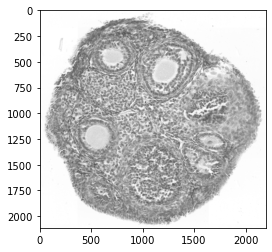

In [1027]:
plt.imshow(fftconvolve(images[0][0].mean(axis=2), np.ones((1,1))), cmap="gray")

In [1051]:
toto = fftconvolve(images[0][0].mean(axis=2), np.array([[0,1,0],[1,1,1],[0,1,0]]))
toto = (toto-toto.mean())/(toto.max()-toto.min())

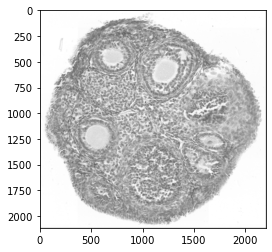

In [1053]:
plt.imshow(toto, cmap="gray")

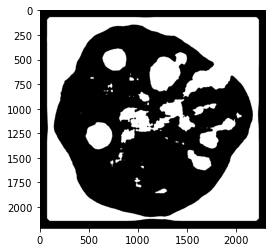

In [1041]:
plt.imshow((toto > 0).astype("int"), cmap="gray")

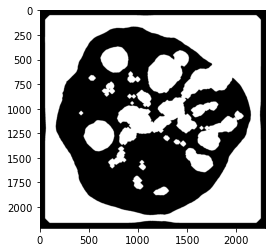

In [1050]:
plt.imshow(morphology.binary_dilation((toto > 0).astype("int"), iterations=20), cmap="gray")

In [986]:
len(images[0])

40

In [954]:
test = lambda x: fftconvolve(
    x,
    np.ones((3,3)),
    mode="same"
)

%timeit test(images[0][0].mean(axis=2))

387 ms ± 74.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [938]:
tests = []
for x in [0,90,180,270]:
    for y in [0,2]:
        if y in [0,1]:
            test = np.flip(test_img, axis=y)
        else:
            test = test_img
        
        tests.append(rotate(test, angle=x))

In [918]:
test_results = {}
for i in range(len(tests)):
    test_results[i] = []
    for j in range(len(tests)):
        x = tests[i]
        y = tests[j]
        
        test_results[i].append(
            (x.shape == y.shape) and ((x-y).sum() == 0)
        )

In [937]:
pd.DataFrame(test_results).values.trace()-((pd.DataFrame(test_results).sum().sum()-pd.DataFrame(test_results).values.trace())/2)

8.0

In [916]:
pd.DataFrame(test_results).sum().sum()

8

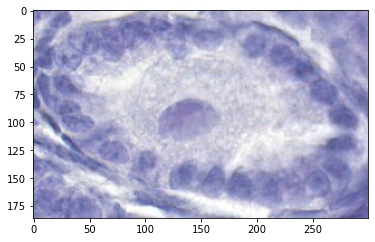

In [820]:
plt.imshow(test_img)

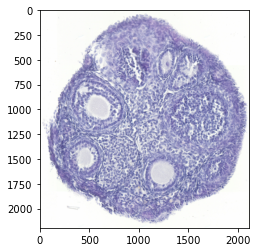

In [777]:
plt.imshow(ndimage.rotate(test_img, 90))

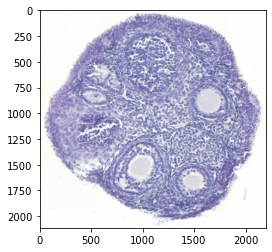

In [764]:
plt.imshow(ndimage.rotate(test_img, 180))

In [757]:
test_img

(2113, 2195, 3)

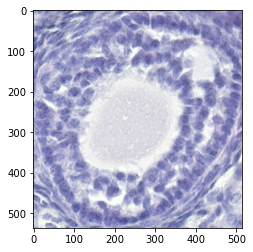

In [752]:
plt.imshow(images[0][0][4])

In [747]:
images[0][2][1]

1.0

In [673]:
image_loader.y_box

{'xmin': array([1512., 1812., 1187., 1373.]),
 'xmax': array([ 202.,  270., 1095., 1160.]),
 'ymin': array([ 362.,  737., 1058., 1404.]),
 'ymax': array([535., 888., 275., 609.])}

In [2]:
from submissions.ab_submission import object_detector
import importlib
importlib.reload(object_detector)

<module 'submissions.ab_submission.object_detector' from 'c:\\Users\\4078182\\Personal\\git\\follicles_detection\\submissions\\ab_submission\\object_detector.py'>

In [100]:
import glob
import imageio
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [4]:
train_files = glob.glob("./data/train/*.jpg")
test_files = glob.glob("./data/test/*.jpg")
train_label = pd.read_csv("./data/train/labels.csv")
test_label = pd.read_csv("./data/test/labels.csv")

train_data = dict([(x.split("\\")[-1], imageio.imread(x)) for x in train_files])
test_data = dict([(x.split("\\")[-1], imageio.imread(x)) for x in test_files])

In [10]:
train_label.query("filename == 'D-1M01-2.jpg'")

,Unnamed: 0,filename,width,height,class,label,xmin,ymin,xmax,ymax
0,0,D-1M01-2.jpg,2194,2112,Primary,2,1512,1187,1812,1373
1,1,D-1M01-2.jpg,2194,2112,Primordial,1,202,1095,270,1160
2,2,D-1M01-2.jpg,2194,2112,Secondary,3,362,1058,737,1404
3,3,D-1M01-2.jpg,2194,2112,Secondary,3,535,275,888,609
4,4,D-1M01-2.jpg,2194,2112,Secondary,3,977,307,1491,843


In [266]:
train_image_label = train_label[
    train_label["filename"] == "D-1M03-5.jpg"
]

train_image_data = train_data['D-1M03-5.jpg'].mean(axis=2)

In [535]:
test_image_label = train_label[
    train_label["filename"] == "D-1M02-2.jpg"
]

test_image_data = train_data['D-1M02-2.jpg'].mean(axis=2)

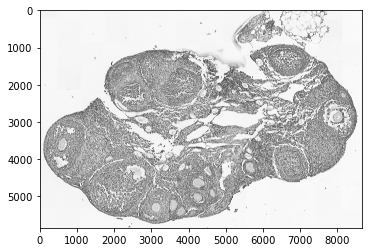

In [536]:
plt.imshow(train_image_data, cmap="gray")

In [537]:
convolve_kernel = np.ones((6,6))
train_image_data_convolve = convolve(train_image_data, convolve_kernel)/convolve_kernel.size
test_image_data_convolve = convolve(test_image_data, convolve_kernel)/convolve_kernel.size

In [538]:
dataset = train_image_label[["label","xmin","xmax","ymin","ymax"]] \
    .assign(pixel_intensity = lambda x: x.apply(
        lambda y: train_image_data_convolve[
            y["ymin"]:y["ymax"], 
            y["xmin"]:y["xmax"]
        ].flatten().tolist(), axis=1)
    )[["label","pixel_intensity"]] \
    .explode("pixel_intensity").dropna()

dataset["label"] = (dataset["label"] != 0).astype("int")
ds_mean = train_image_data_convolve.mean()
ds_min = train_image_data_convolve.min()
ds_max = train_image_data_convolve.max()
dataset["pixel_intensity"] = (dataset["pixel_intensity"]-ds_mean)/(ds_max-ds_min)

In [539]:
test_values = ((test_image_data_convolve-test_image_data_convolve.mean())/(test_image_data_convolve.max()-test_image_data_convolve.min())).reshape(-1,1)

In [540]:
from sklearn.tree import DecisionTreeClassifier

pixel_intensity_model = DecisionTreeClassifier(max_depth=3, class_weight={0:1, 1:1})

In [541]:
pixel_intensity_model.fit(dataset[["pixel_intensity"]].values, dataset["label"])

DecisionTreeClassifier(class_weight={0: 1, 1: 1}, max_depth=3)

In [542]:
pixel_intensity_model.score(dataset[["pixel_intensity"]].values, dataset["label"])

0.5528589343700452

In [543]:
test_values_loc = pixel_intensity_model.predict(test_values)

In [544]:
test_image_data_convolve_filtered = (1-test_values_loc.reshape(test_image_data_convolve.shape))*test_image_data_convolve

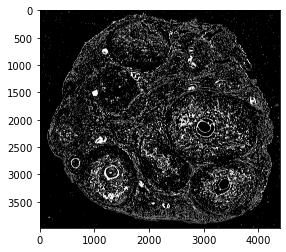

In [545]:
plt.imshow(test_image_data_convolve_filtered, cmap="gray")

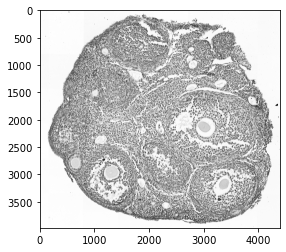

In [546]:
plt.imshow(test_image_data_convolve, cmap="gray")

In [311]:
from scipy.ndimage import morphology, convolve

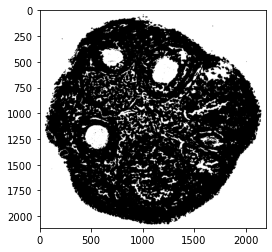

In [156]:
threshold = 0.05
convolve_kernel = np.ones((5,5))
convolve_test = convolve(test, convolve_kernel)/convolve_kernel.size
binary_image = (convolve_test > threshold).astype("int")
plt.imshow(binary_image, cmap = "gray")
plt.show()

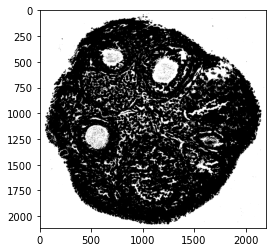

In [152]:
threshold = 0.05
convolve_kernel = np.ones((3,3))
binary_image = (test > threshold).astype("int")
plt.imshow(binary_image, cmap = "gray")
plt.show()

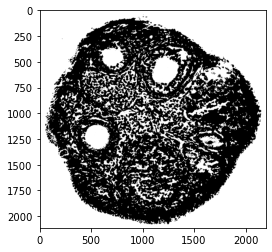

In [153]:
dilatation_mask = np.ones((3,3))
binary_image_processed = morphology.binary_dilation(binary_image, iterations=2)

plt.imshow(binary_image_processed, cmap = "gray")
plt.show()

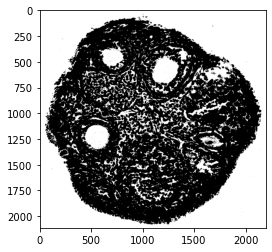

In [60]:
threshold = -0.1
binary_image = morphology.binary_dilation(
    (test <= threshold).astype("int")
)
plt.imshow(binary_image, cmap = "gray")

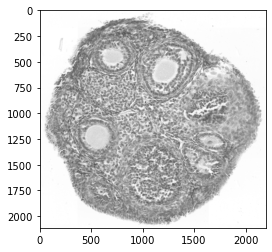

In [49]:
plt.imshow(test, cmap = "gray")